In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
open_eyes_dir = "/content/drive/MyDrive/FIVP_INNOVATIVE/train_new/Open"
closed_eyes_dir = "/content/drive/MyDrive/FIVP_INNOVATIVE/train_new/Closed"
yawn_dir = "/content/drive/MyDrive/FIVP_INNOVATIVE/train_new/yawn"
no_yawn_dir = "/content/drive/MyDrive/FIVP_INNOVATIVE/train_new/no_yawn"

In [ ]:
image_height, image_width = 100, 100
epochs = 100
batch_size = 32

In [ ]:
def load_and_preprocess_images(directory, label):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = tf.keras.preprocessing.image.load_img(os.path.join(directory, filename), target_size=(image_height, image_width))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)

    return images, labels

In [ ]:
open_eyes_images, open_eyes_labels = load_and_preprocess_images(open_eyes_dir, 0)  # Label 0 for "open_eyes"
closed_eyes_images, closed_eyes_labels = load_and_preprocess_images(closed_eyes_dir, 1)  # Label 1 for "closed_eyes"
yawn_images, yawn_labels = load_and_preprocess_images(yawn_dir, 2)  # Label 2 for "yawn"
no_yawn_images, no_yawn_labels = load_and_preprocess_images(no_yawn_dir, 3)  # Label 3 for "no_yawn"

In [ ]:
X = np.concatenate((open_eyes_images, closed_eyes_images, yawn_images, no_yawn_images), axis=0)
y = np.concatenate((np.zeros(len(open_eyes_labels)), np.ones(len(closed_eyes_labels)), np.full(len(yawn_labels), 2),np.full(len(no_yawn_labels), 3)), axis=0)

In [ ]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, y_train = X[:split_index], y[:split_index]
X_val, y_val = X[split_index:], y[split_index:]

In [ ]:
y_encoded = to_categorical(y, num_classes=4)

Model 1 - Convolutional Neural Network (CNN)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Four classes: "open_eyes", "closed_eyes", "yawn", "no_yawn"
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_encoded[:split_index], epochs=epochs, validation_data=(X_val, y_encoded[split_index:]))

Epoch 1/100
73/73 [==============================] - 7s 30ms/step - loss: 1.1892 - accuracy: 0.4148 - val_loss: 0.7250 - val_accuracy: 0.7363
Epoch 2/100
73/73 [==============================] - 1s 17ms/step - loss: 0.6905 - accuracy: 0.6935 - val_loss: 0.5107 - val_accuracy: 0.7568
Epoch 3/100
73/73 [==============================] - 1s 14ms/step - loss: 0.5364 - accuracy: 0.7453 - val_loss: 0.4359 - val_accuracy: 0.7654
Epoch 4/100
73/73 [==============================] - 1s 14ms/step - loss: 0.4763 - accuracy: 0.7791 - val_loss: 0.4005 - val_accuracy: 0.7997
Epoch 5/100
73/73 [==============================] - 1s 14ms/step - loss: 0.4416 - accuracy: 0.7838 - val_loss: 0.3791 - val_accuracy: 0.7979
Epoch 6/100
73/73 [==============================] - 1s 14ms/step - loss: 0.4204 - accuracy: 0.7928 - val_loss: 0.3667 - val_accuracy: 0.7997
Epoch 7/100
73/73 [==============================] - 1s 14ms/step - loss: 0.3896 - accuracy: 0.7949 - val_loss: 0.3845 - val_accuracy: 0.7757
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_encoded[split_index:], verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

19/19 - 0s - loss: 0.1443 - accuracy: 0.9692 - 114ms/epoch - 6ms/step
Test Loss: 0.14427071809768677
Test Accuracy: 0.9691780805587769


19/19 [==============================] - 0s 4ms/step


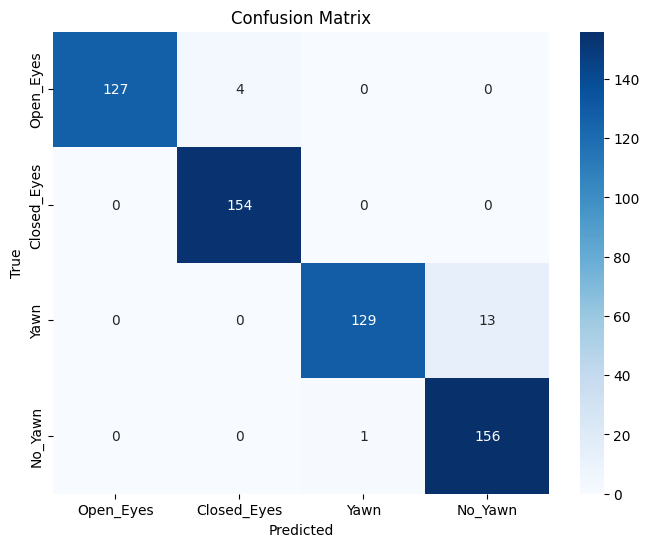

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = model.predict(X_val)


y_true = np.argmax(y_encoded[split_index:], axis=1)
y_pred = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Open_Eyes', 'Closed_Eyes', 'Yawn', 'No_Yawn'], yticklabels=['Open_Eyes', 'Closed_Eyes', 'Yawn', 'No_Yawn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
class_names = ['Open_Eyes', 'Closed_Eyes', 'Yawn', 'No_Yawn']
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)

              precision    recall  f1-score   support

   Open_Eyes       1.00      0.97      0.98       131
 Closed_Eyes       0.97      1.00      0.99       154
        Yawn       0.99      0.91      0.95       142
     No_Yawn       0.92      0.99      0.96       157

    accuracy                           0.97       584
   macro avg       0.97      0.97      0.97       584
weighted avg       0.97      0.97      0.97       584



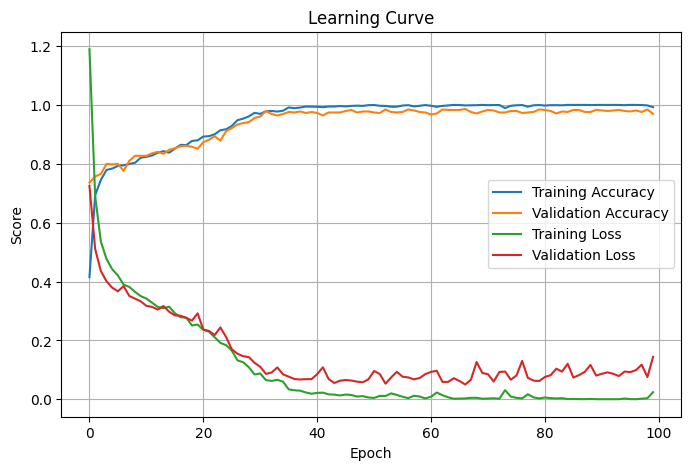

In [ ]:
# learning curve

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

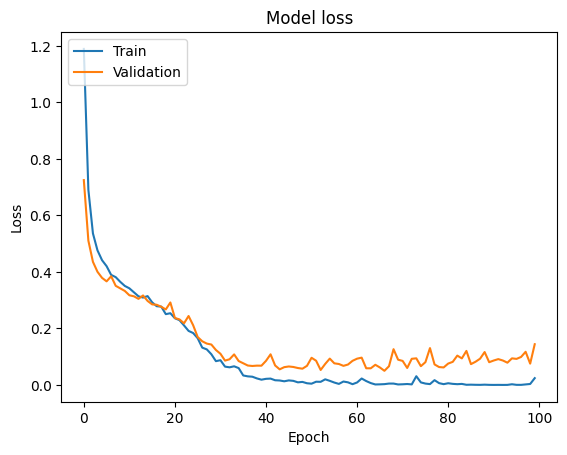

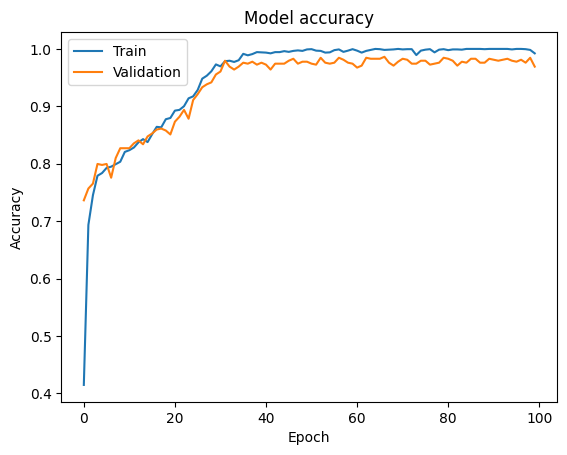

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# After training your model, save it to a file
model.save("/content/drive/MyDrive/ML_INNOVATIVE/model1_cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Prediction

In [ ]:
# Load the trained model
model_path = "/content/drive/MyDrive/ML_INNOVATIVE/model1_cnn.h5"
model = tf.keras.models.load_model(model_path)

# Define the input image path
input_image_path = "/content/drive/MyDrive/ML_INNOVATIVE/test_new/1.jpg"
image_height = 100
image_width = 100

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np


def check_drowsiness(model, image_path, image_height, image_width):
    # Load and preprocess the input image
    img = image.load_img(image_path, target_size=(image_height, image_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions using the model
    predictions = model.predict(img_array)

    # Define class labels
    class_labels = ['Open_Eyes', 'Closed_Eyes', 'Yawn', 'No_Yawn']

    # Determine drowsiness
    if predictions[0, 0] > 0.5 or predictions[0, 3] > 0.5:
        return "Not drowsy"
    else:
        return "Drowsy"

result = check_drowsiness(model, input_image_path, image_height, image_width)
print("Drowsiness Status:", result)


1/1 [==============================] - 0s 306ms/step
Drowsiness Status: Drowsy


In [ ]:
def check_drowsiness(model, image_path, image_height, image_width):
    # Load and preprocess the input image
    img = image.load_img(image_path, target_size=(image_height, image_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions using the model
    predictions = model.predict(img_array)

    # Define class labels
    class_labels = ["open_eyes_no_yawn", "closed_eyes_no_yawn", "open_eyes_yawn", "closed_eyes_yawn"]

    # Thresholds for considering a class
    thresholds = [0.5, 0.5, 0.5, 0.5]

    # Check if eyes are closed
    if predictions[0, 1] > thresholds[1]:
        return "Drowsy"

    # Check if eyes are open and there is a yawn
    elif predictions[0, 2] > thresholds[2]:
        return "Drowsy"

    # Check if eyes are open, no yawn, and weak posture
    elif predictions[0, 5] > thresholds[5]:
        return "Drowsy"

    # If none of the above conditions are met, consider as not drowsy
    return "Not drowsy"


In [ ]:
result = check_drowsiness(model, input_image_path, image_height, image_width)
print("Drowsiness Status:", result)

1/1 [==============================] - 0s 17ms/step
Drowsiness Status: Drowsy


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from math import ceil

def predict_and_display_for_folder(model, folder_path, image_height, image_width, images_per_row=3):
    # Get a list of all files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Calculate the number of rows needed
    num_rows = ceil(len(image_files) / images_per_row)

    # Iterate through each image and make predictions
    for row in range(num_rows):
        fig, axes = plt.subplots(1, images_per_row, figsize=(15, 5))

        for col in range(images_per_row):
            image_index = row * images_per_row + col
            if image_index < len(image_files):
                image_file = image_files[image_index]
                image_path = os.path.join(folder_path, image_file)

                # Load and preprocess the input image
                img = Image.open(image_path)
                img_array = np.array(img.resize((image_width, image_height))) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                # Make predictions using the model
                predictions = model.predict(img_array)

                # Thresholds for considering a class
                thresholds = [0.5, 0.5, 0.5, 0.5]

                # Check if eyes are closed
                if predictions[0, 1] > thresholds[1]:
                    result = "Drowsy"

                # Check if eyes are open and there is a yawn
                elif predictions[0, 2] > thresholds[2]:
                    result = "Drowsy"

                # If none of the above conditions are met, consider as not drowsy
                else:
                    result = "Not drowsy"

                # Display the image and prediction
                axes[col].imshow(img)
                axes[col].set_title(f"{image_file}\nPrediction: {result}")
                axes[col].axis('off')

        plt.show()

1/1 [==============================] - 0s 20ms/step


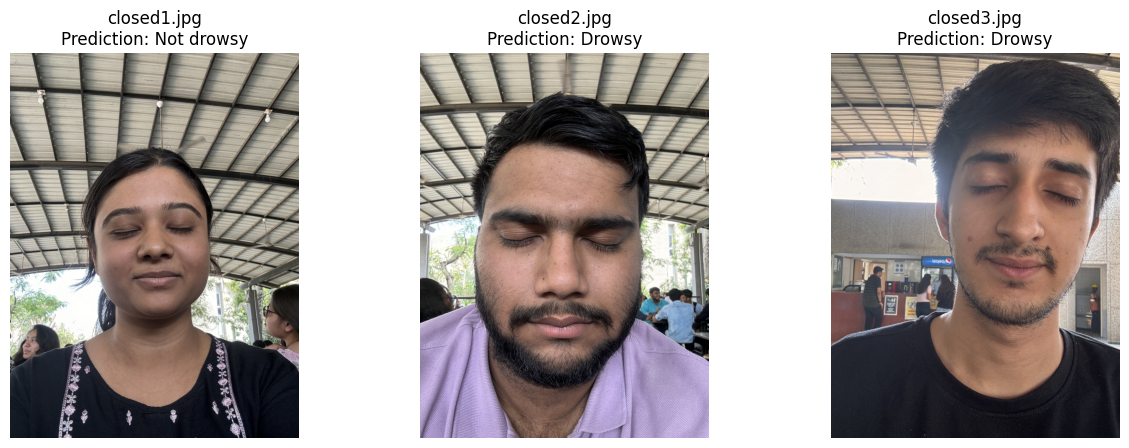

1/1 [==============================] - 0s 27ms/step


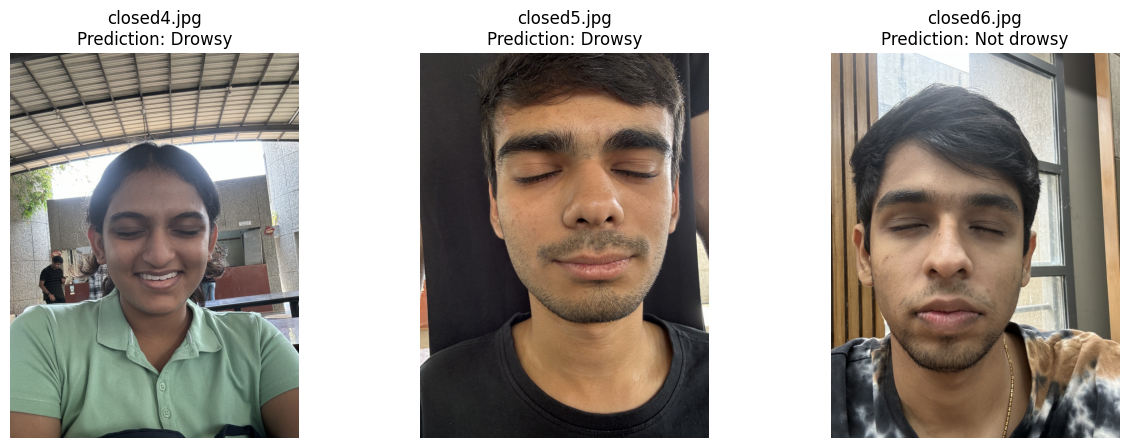

1/1 [==============================] - 0s 26ms/step


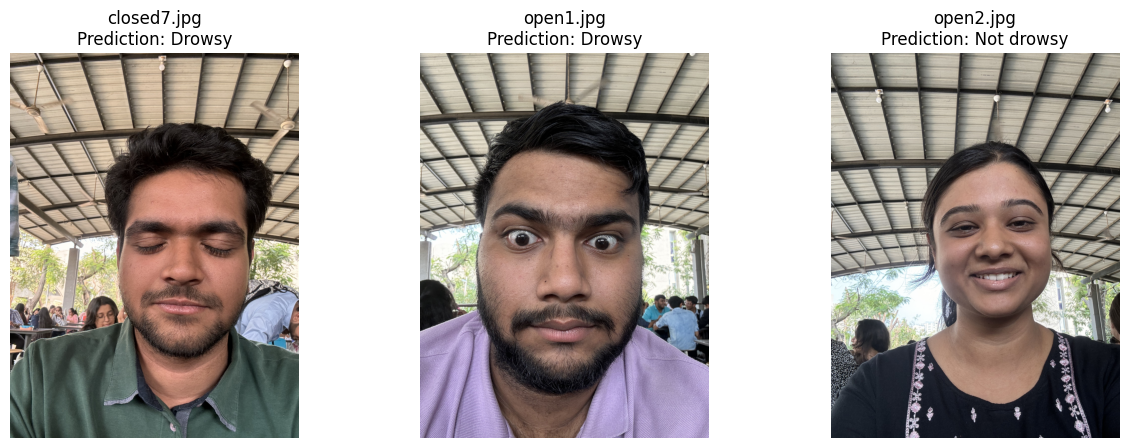

1/1 [==============================] - 0s 18ms/step


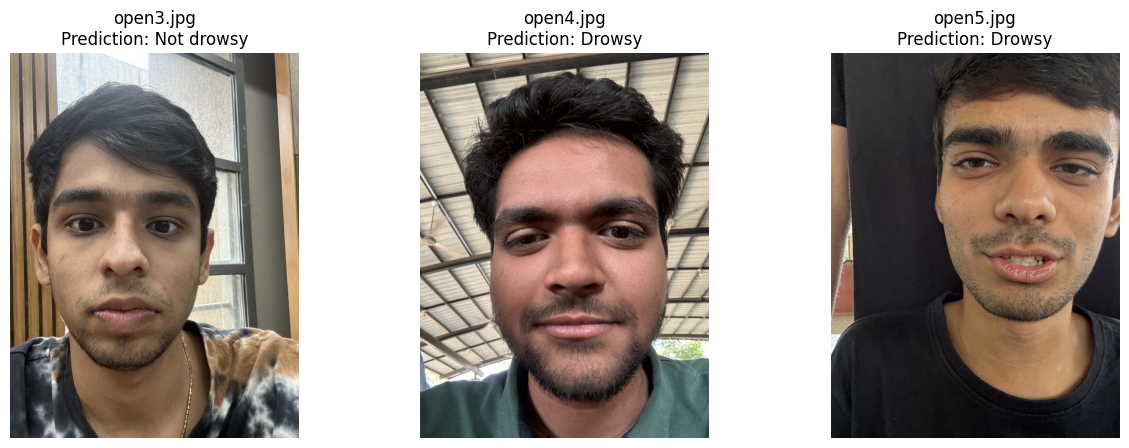

1/1 [==============================] - 0s 17ms/step


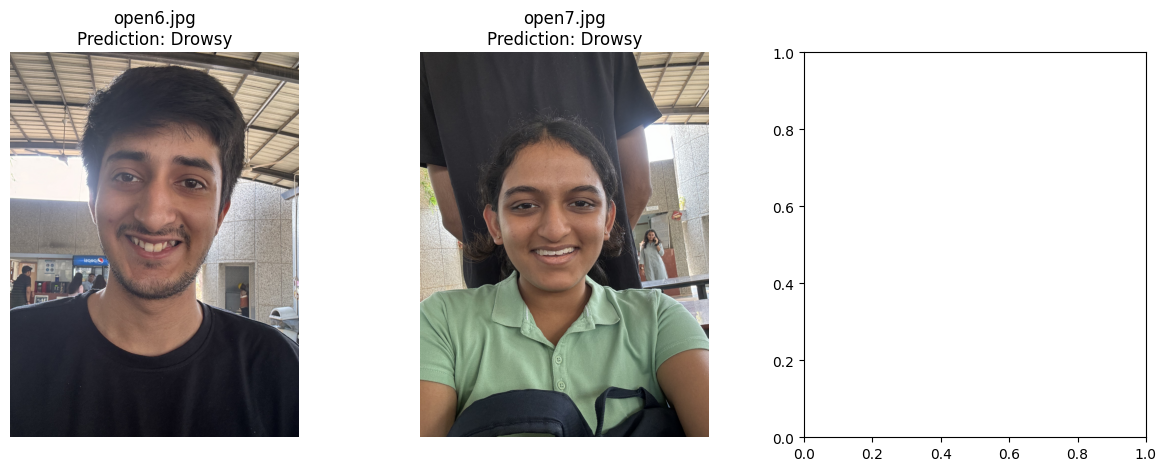

In [ ]:
# Example usage:
folder_path = "/content/drive/MyDrive/ML_INNOVATIVE/test_new/JPG"
predict_and_display_for_folder(model, folder_path, image_height, image_width)

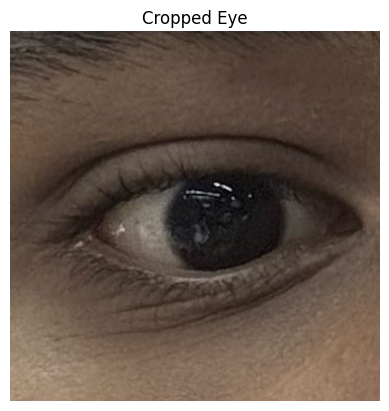

True

In [ ]:
import cv2
import matplotlib.pyplot as plt

def crop_eye(image_path):
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load the image.")
        return None

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained haarcascade eye classifier
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Detect eyes in the image
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Crop the eyes from the image
    if len(eyes) > 0:
        (x, y, w, h) = eyes[0]
        cropped_eye = image[y:y+h, x:x+w]

        # Resize the cropped eye image to fit the input shape of the model
        resized_eye = cv2.resize(cropped_eye, (145, 145))

        # Preprocess the image for the model
        normalized_eye = resized_eye / 255.0
        input_data = normalized_eye.reshape(1, 145, 145, 3)

        # Display the cropped eye image
        plt.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Eye")
        plt.axis('off')
        plt.show()

        return cropped_eye  # Return the cropped eye image

    return None  # Return None if no eyes were detected



# Input image path
image_path = "/content/drive/MyDrive/ML_INNOVATIVE/train/IMG_1326.jpg"
cropped_eye = crop_eye(image_path)

cv2.imwrite("cropped_eye_open_h.jpg", cropped_eye)


Model 2 - Artificial Neural Network (ANN)

In [ ]:
num_classes = 4

In [ ]:
model_ann = Sequential([
    Flatten(input_shape=(image_height, image_width, 3)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model_ann.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded = to_categorical(y_val, num_classes)

In [ ]:
epochs = 100
history = model_ann.fit(X_train, y_train_encoded, epochs=epochs, validation_data=(X_val, y_val_encoded))

Epoch 1/100
73/73 [==============================] - 3s 13ms/step - loss: 1.1902 - accuracy: 0.4867 - val_loss: 0.6734 - val_accuracy: 0.7295
Epoch 2/100
73/73 [==============================] - 1s 7ms/step - loss: 0.7617 - accuracy: 0.6468 - val_loss: 0.5478 - val_accuracy: 0.7363
Epoch 3/100
73/73 [==============================] - 1s 7ms/step - loss: 0.6827 - accuracy: 0.6747 - val_loss: 0.5393 - val_accuracy: 0.7534
Epoch 4/100
73/73 [==============================] - 1s 7ms/step - loss: 0.6065 - accuracy: 0.6986 - val_loss: 0.4854 - val_accuracy: 0.7705
Epoch 5/100
73/73 [==============================] - 1s 7ms/step - loss: 0.5720 - accuracy: 0.7123 - val_loss: 0.4568 - val_accuracy: 0.7723
Epoch 6/100
73/73 [==============================] - 1s 8ms/step - loss: 0.5601 - accuracy: 0.7277 - val_loss: 0.4775 - val_accuracy: 0.7568
Epoch 7/100
73/73 [==============================] - 1s 7ms/step - loss: 0.5281 - accuracy: 0.7432 - val_loss: 0.4561 - val_accuracy: 0.7740
Epoch 8/100


In [ ]:
test_loss, test_acc = model_ann.evaluate(X_val, y_val_encoded, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

19/19 - 0s - loss: 0.2387 - accuracy: 0.9024 - 77ms/epoch - 4ms/step
Test Loss: 0.23868484795093536
Test Accuracy: 0.9023972749710083


In [ ]:
# After training your model, save it to a file
model_ann.save("/content/drive/MyDrive/ML_INNOVATIVE/model1_ann.h5")

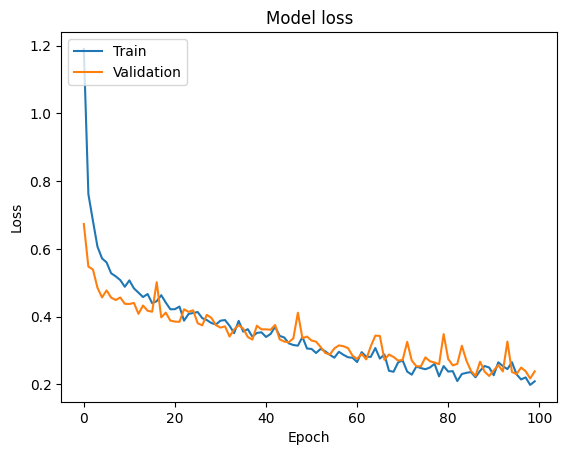

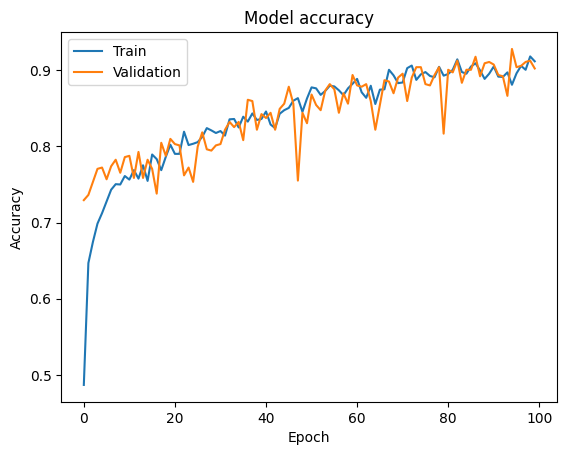

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Model 3 - EfficientNetB0

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
model_eff = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
test_losses = []
test_accuracies = []
fold_histories = []
epochs_eff = 10

In [ ]:
for train_indices, val_indices in kf.split(X):
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    y_train_encoded = to_categorical(y_train, num_classes=4)
    y_val_encoded = to_categorical(y_val, num_classes=4)

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)

    model_eff = Model(inputs=base_model.input, outputs=predictions)

    model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model_eff.fit(X_train, y_train_encoded, epochs=epochs_eff, validation_data=(X_val, y_val_encoded))

    fold_histories.append(history)

    test_loss, test_acc = model_eff.evaluate(X_val, y_val_encoded, verbose=0)
    print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_acc}")

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

avg_test_loss = np.mean(test_losses)
avg_test_acc = np.mean(test_accuracies)
print(f"Average Test Loss: {avg_test_loss}, Average Test Accuracy: {avg_test_acc}")

Epoch 1/10
73/73 [==============================] - 49s 121ms/step - loss: 0.6517 - accuracy: 0.7684 - val_loss: 1.5489 - val_accuracy: 0.2723
Epoch 2/10
73/73 [==============================] - 5s 75ms/step - loss: 0.2082 - accuracy: 0.9298 - val_loss: 1.7961 - val_accuracy: 0.2329
Epoch 3/10
73/73 [==============================] - 5s 75ms/step - loss: 0.0753 - accuracy: 0.9790 - val_loss: 1.8754 - val_accuracy: 0.2637
Epoch 4/10
73/73 [==============================] - 8s 109ms/step - loss: 0.0634 - accuracy: 0.9786 - val_loss: 2.6382 - val_accuracy: 0.3459
Epoch 5/10
73/73 [==============================] - 8s 108ms/step - loss: 0.0431 - accuracy: 0.9837 - val_loss: 2.5044 - val_accuracy: 0.3356
Epoch 6/10
73/73 [==============================] - 6s 82ms/step - loss: 0.0514 - accuracy: 0.9824 - val_loss: 1.9969 - val_accuracy: 0.3390
Epoch 7/10
73/73 [==============================] - 5s 75ms/step - loss: 0.0382 - accuracy: 0.9876 - val_loss: 1.8421 - val_accuracy: 0.3630
Epoch 8/1

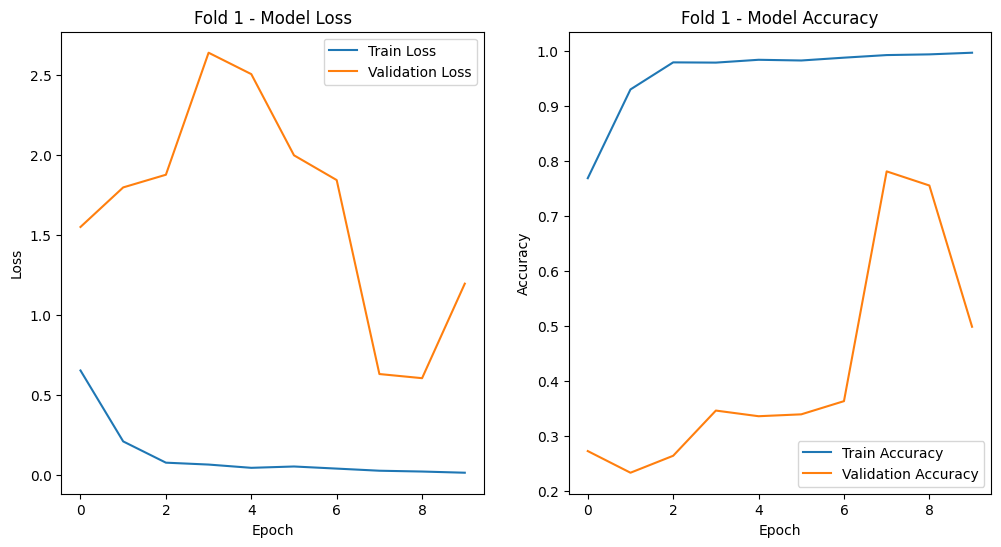

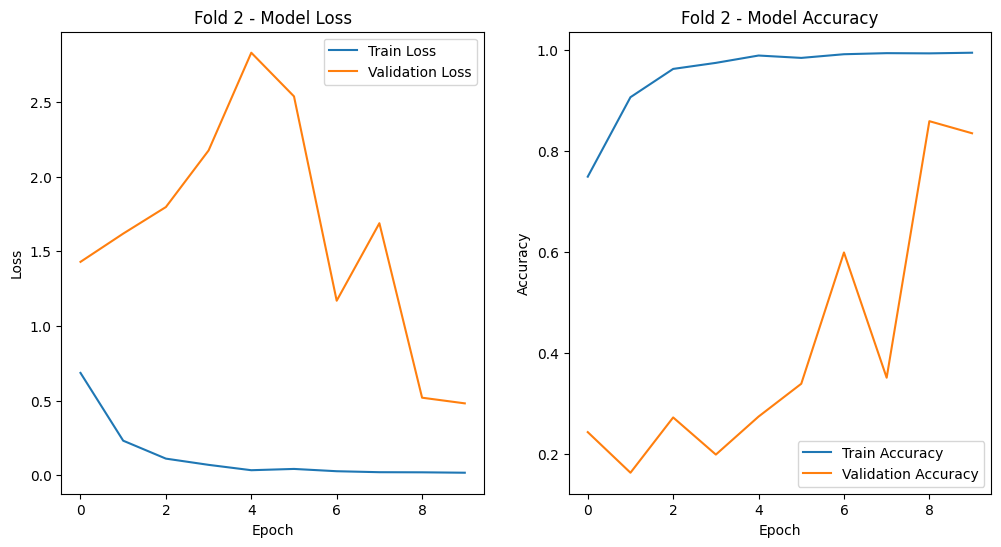

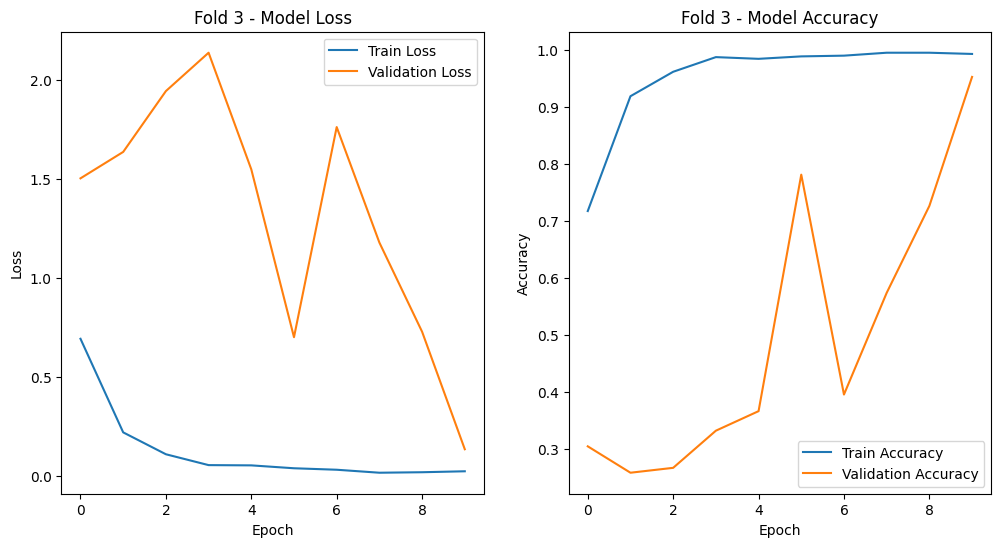

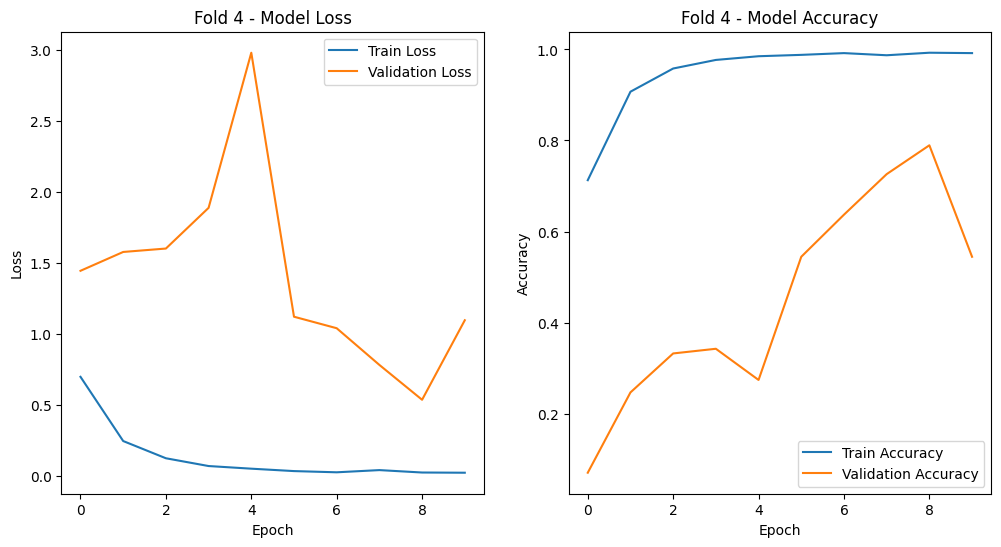

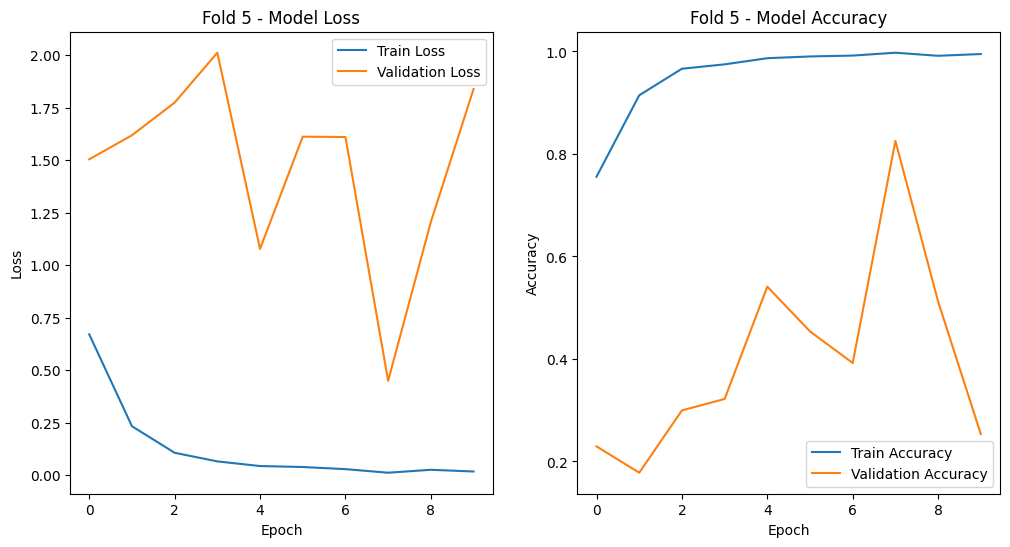

In [ ]:
for i, history in enumerate(fold_histories):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()